In [5259]:
"""
    房价预测问题是一个回归问题，这个完成之后就试试
    泰坦尼克号生存预测，是一个分类问题
    电影评论的情感分析，一个短文本分类问题，会涉及到一些文本，语言方面的处理，还会用到深度学习
"""

'\n    房价预测问题是一个回归问题，这个完成之后就试试\n    泰坦尼克号生存预测，是一个分类问题\n    电影评论的情感分析，一个短文本分类问题，会涉及到一些文本，语言方面的处理，还会用到深度学习\n'

In [5260]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline
plt.style.use("ggplot")

import os
print(os.listdir("./data"))

# Any results you write to the current directory are saved as output.

['data_description.txt', 'test.csv', 'train.csv', 'sample_submission.csv']


In [5261]:
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.preprocessing import RobustScaler, StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.metrics import mean_squared_error
from scipy.stats import skew
from sklearn.decomposition import PCA, KernelPCA
from sklearn.preprocessing import Imputer

In [5262]:
from sklearn.model_selection import cross_val_score, GridSearchCV, KFold
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor
from sklearn.svm import SVR, LinearSVR
from sklearn.linear_model import ElasticNet, SGDRegressor, BayesianRidge
from sklearn.kernel_ridge import KernelRidge
from xgboost import XGBRegressor
import xgboost as xgb
import lightgbm as lgb

In [5263]:
train = pd.read_csv("./data/train.csv")
test = pd.read_csv("./data/test.csv")

In [5264]:
#观察因变量的数据特征，看数据分布是否均衡
train["SalePrice"].describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

(array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
         13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
         26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
         39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
         52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
         65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
         78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
         91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
        104, 105, 106, 107, 108, 109, 110, 111]),
 <a list of 112 Text xticklabel objects>)

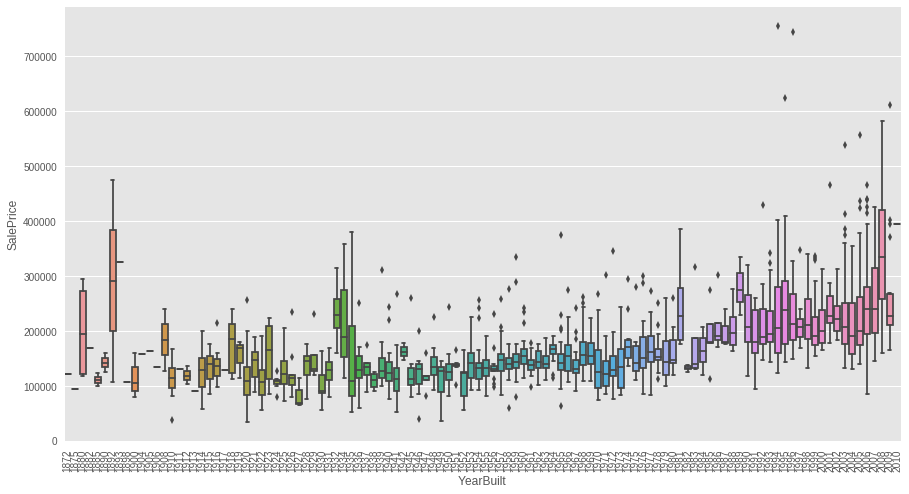

In [5265]:
#因变量SalePrice随特征YearBuilt的分布变化
plt.figure(figsize=(15,8))
sns.boxplot(train.YearBuilt, train.SalePrice)
plt.xticks(rotation=90)

In [5266]:
"""
Data Cleaning（处理缺失值和异常值）：
    处理异常值：
        利用散点图，和正态分布规范化之后的数据分布值，去除异常值
    处理缺失值：
        观察数据描述,发现该特征缺失时，应该怎么处理，是否与其他特征有关，可以其他特征值变向替代，或取其他样本的值有关：
            有些数据值缺失的应该是需要用0来进行填充，就填充0(该列的数据类型应该是numeric)
            有些数据值缺失用None来进行填充(该列的数据类型应该是object)
            还有一些特征，理所应当一定是有值的，所以一定不能填充0，也不能是None,这时就要找与它极度相关的特征进行填充，或者是其他样本的值
            中位数，众数等
        用到的方法包括：groupby,fillna
"""

'\nData Cleaning（处理缺失值和异常值）：\n    处理异常值：\n        利用散点图，和正态分布规范化之后的数据分布值，去除异常值\n    处理缺失值：\n        观察数据描述,发现该特征缺失时，应该怎么处理，是否与其他特征有关，可以其他特征值变向替代，或取其他样本的值有关：\n            有些数据值缺失的应该是需要用0来进行填充，就填充0(该列的数据类型应该是numeric)\n            有些数据值缺失用None来进行填充(该列的数据类型应该是object)\n            还有一些特征，理所应当一定是有值的，所以一定不能填充0，也不能是None,这时就要找与它极度相关的特征进行填充，或者是其他样本的值\n            中位数，众数等\n        用到的方法包括：groupby,fillna\n'

(0, 800000)

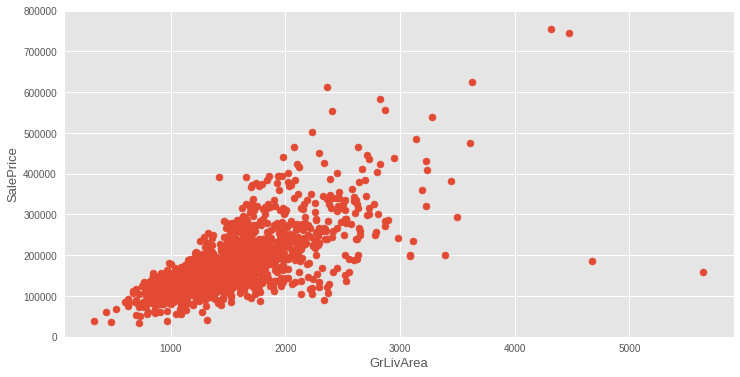

In [5267]:
#画出GrLivArea和SalePrice的散点图（可以用来发现异常点）
plt.figure(figsize=(12,6))
plt.scatter(x=train.GrLivArea, y=train.SalePrice)
plt.xlabel("GrLivArea", fontsize=13)
plt.ylabel("SalePrice", fontsize=13)
plt.ylim(0, 800000)

In [5268]:
#利用条件判断来进行删除,inplace=True,不创建新的对象，直接在原始的对象上进行修改
train.drop(train[(train["GrLivArea"]>4000) & (train["SalePrice"]<200000)].index, inplace=True)

In [5269]:
#将train和test整合到同一个df中，concat没制定axis就意味着在行的方向上进行扩充
full = pd.concat([train, test], ignore_index=True)
print(full.shape)

(2917, 81)


In [5270]:
full.head(5)

,1stFlrSF,2ndFlrSF,3SsnPorch,Alley,BedroomAbvGr,BldgType,BsmtCond,BsmtExposure,BsmtFinSF1,BsmtFinSF2,...,SaleType,ScreenPorch,Street,TotRmsAbvGrd,TotalBsmtSF,Utilities,WoodDeckSF,YearBuilt,YearRemodAdd,YrSold
0,856,854,0,NaN,3,1Fam,TA,No,706.0,0.0,...,WD,0,Pave,8,856.0,AllPub,0,2003,2003,2008
1,1262,0,0,NaN,3,1Fam,TA,Gd,978.0,0.0,...,WD,0,Pave,6,1262.0,AllPub,298,1976,1976,2007
2,920,866,0,NaN,3,1Fam,TA,Mn,486.0,0.0,...,WD,0,Pave,6,920.0,AllPub,0,2001,2002,2008
3,961,756,0,NaN,3,1Fam,Gd,No,216.0,0.0,...,WD,0,Pave,7,756.0,AllPub,0,1915,1970,2006
4,1145,1053,0,NaN,4,1Fam,TA,Av,655.0,0.0,...,WD,0,Pave,9,1145.0,AllPub,192,2000,2000,2008


In [5271]:
#不懂为什么要删除id，因为id这一个特征对于predict无法起到任何的帮助
full.drop(["Id"], axis=1, inplace=True)

In [5272]:
train.shape
test.shape

(1459, 80)

In [5273]:
#输出数据缺失的情况
aa = full.isnull().sum()
aa_missing = aa[aa>0].sort_values(ascending=False)[:30]
aa_missing

PoolQC          2908
MiscFeature     2812
Alley           2719
Fence           2346
SalePrice       1459
FireplaceQu     1420
LotFrontage      486
GarageQual       159
GarageCond       159
GarageFinish     159
GarageYrBlt      159
GarageType       157
BsmtExposure      82
BsmtCond          82
BsmtQual          81
BsmtFinType2      80
BsmtFinType1      79
MasVnrType        24
MasVnrArea        23
MSZoning           4
BsmtFullBath       2
BsmtHalfBath       2
Utilities          2
Functional         2
Electrical         1
BsmtUnfSF          1
Exterior1st        1
Exterior2nd        1
TotalBsmtSF        1
GarageCars         1
dtype: int64

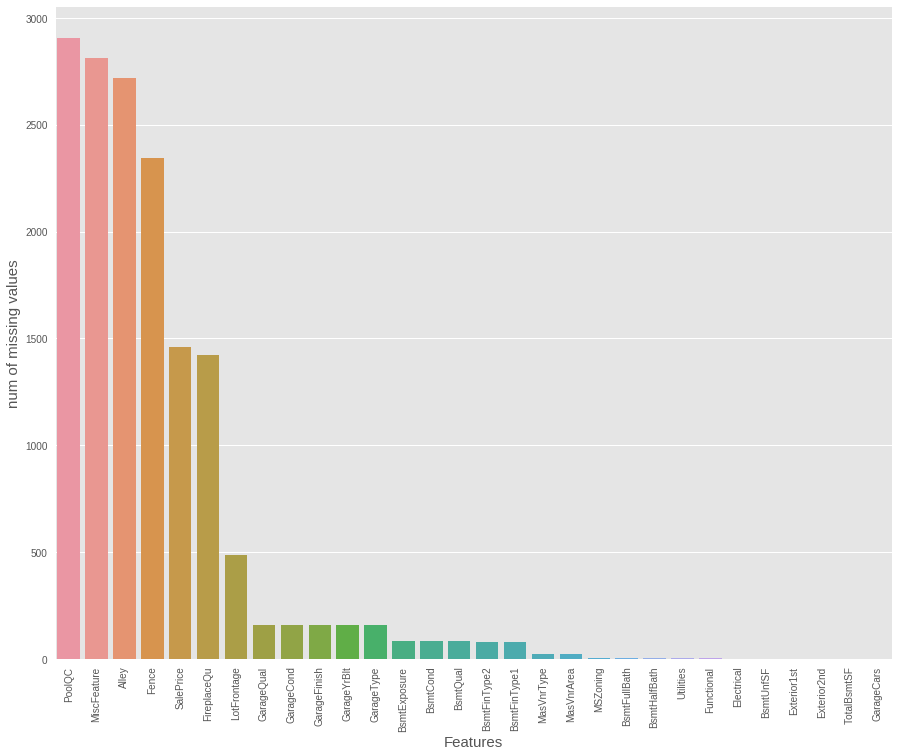

In [5274]:
#缺失值图像
f,ax = plt.subplots(figsize=(15, 12))
plt.xticks(rotation="90")
sns.barplot(x=aa_missing.index, y=aa_missing.values)
plt.xlabel("Features", fontsize=15)
plt.ylabel("num of missing values", fontsize=15)

In [5275]:
# loc的使用，输出某一行，对应列的所有数据
# full.loc[666,["GarageQual","GarageCond","GarageFinish","GarageYrBlt"]]

In [5276]:
#检查缺失某个特征列与另一列的情况联系起来
#full[full["BsmtExposure"].isnull() & full["Fireplaces"]>0]
# full[full["PoolQC"].isnull() & full["PoolArea"]>0][["PoolQC","PoolArea"]]

# full[full["GarageQual"].isnull()][['GarageQual','GarageCond','GarageFinish','GarageYrBlt','GarageType','GarageCars','GarageArea']]
# full[full["GarageYrBlt"].isnull() & full["GarageArea"]>0][['GarageQual','GarageCond','GarageFinish','GarageYrBlt','GarageType','GarageCars','GarageArea']]
#full["GarageCars"].dtypes

In [5277]:
"""
   0:BsmtFinSF1,BsmtFinSF2,TotalBsmtSF(没有地下室)
   0:BsmtFullBath,BsmtHalfBath（没有地下室）
   0:BsmtFinType1,BsmtUnfSF
   判断TotalBsmtSF(0/非0分开处理):BsmtFinType2,BsmtQual(判断TotalBsmtSF),BsmtCond,BsmtExposure
   0:GarageArea,GarageCars
   None:GarageType,
   判断GarageArea(0/非0分开处理):GarageFinish，GarageQual，GarageYrBlt，GarageCond
   mode()或分区mode():SaleType,KitchenQual,Exterior1st,Exterior2nd,Electrical,Utilities,Functional,
   没思路：MSZoning，LotFrontage,
   None:MasVnrType
   0:MasVnrArea
   None:FireplaceQu(没有壁炉)，Fence，MiscFeature
   和street有关：Alley
   PoolQC:和PoolArea有关，可以设置为None，有一个例外;
"""

'\n   0:BsmtFinSF1,BsmtFinSF2,TotalBsmtSF(没有地下室)\n   0:BsmtFullBath,BsmtHalfBath（没有地下室）\n   0:BsmtFinType1,BsmtUnfSF\n   判断TotalBsmtSF(0/非0分开处理):BsmtFinType2,BsmtQual(判断TotalBsmtSF),BsmtCond,BsmtExposure\n   0:GarageArea,GarageCars\n   None:GarageType,\n   判断GarageArea(0/非0分开处理):GarageFinish，GarageQual，GarageYrBlt，GarageCond\n   mode()或分区mode():SaleType,KitchenQual,Exterior1st,Exterior2nd,Electrical,Utilities,Functional,\n   没思路：MSZoning，LotFrontage,\n   None:MasVnrType\n   0:MasVnrArea\n   None:FireplaceQu(没有壁炉)，Fence，MiscFeature\n   和street有关：Alley\n   PoolQC:和PoolArea有关，可以设置为None，有一个例外;\n'

In [5278]:
#按照Neighborhood的每一个取值进行分组，然后求每一个小集合中LotFontage的均值，中位数和数量
# agg,对列进行聚合
full.groupby(["Neighborhood"])[["LotFrontage"]].agg(["mean","median","count"])

LotFrontage             
                    mean median count
Neighborhood                         
Blmngtn        46.900000   43.0    20
Blueste        27.300000   24.0    10
BrDale         21.500000   21.0    30
BrkSide        55.789474   51.0    95
ClearCr        88.150000   80.5    20
CollgCr        71.336364   70.0   220
Crawfor        69.951807   70.0    83
Edwards        65.153409   64.5   176
Gilbert        74.207207   64.0   111
IDOTRR         62.241379   60.0    87
MeadowV        25.606061   21.0    33
Mitchel        75.144444   74.0    90
NAmes          75.210667   73.0   375
NPkVill        28.142857   24.0    21
NWAmes         81.517647   80.0    85
NoRidge        91.629630   89.0    54
NridgHt        84.184049   92.0   163
OldTown        61.777293   60.0   229
SWISU          59.068182   60.0    44
Sawyer         74.551020   72.0    98
SawyerW        70.669811   67.0   106
Somerst        64.549383   72.5   162
StoneBr        62.173913   60.0    46
Timber         81.157895   82.0    57
Veenker        72.000000   80.0    16

In [5279]:
#pd.qcut将对应的数组切成相同的k份,按照LotArea的最小值和最大值，将LotArea切分成10份，将每个区间分给以前的值所在的区间
#LotArea 占地面积，分成十种级别的大小
full["LotAreaCut"] = pd.qcut(full.LotArea, 10)

In [5280]:
#按照LotAreaCut进行分组，然后对列进行聚合
full.groupby(["LotAreaCut"])[["LotFrontage"]].agg(["mean","median","count"])

LotFrontage             
                           mean median count
LotAreaCut                                  
(1299.999, 4921.8]    35.741036   34.0   251
(4921.8, 7007.2]      55.460674   52.0   267
(7007.2, 7949.0]      62.959839   62.0   249
(7949.0, 8740.4]      67.113725   65.0   255
(8740.4, 9452.0]      69.959184   70.0   245
(9452.0, 10148.8]     73.988235   75.0   255
(10148.8, 11000.0]    73.636364   75.0   253
(11000.0, 12196.8]    83.371681   82.0   226
(12196.8, 14285.8]    84.973684   85.0   228
(14285.8, 215245.0]   92.846535   90.0   202

In [5281]:
# full['LotFrontage']=full.groupby(['LotAreaCut','Neighborhood'])['LotFrontage'].transform(lambda x: x.fillna(x.median()))

In [5282]:
# Since some combinations of LotArea and Neighborhood are not available, so we just LotAreaCut alone.
# full['LotFrontage']=full.groupby(['LotAreaCut'])['LotFrontage'].transform(lambda x: x.fillna(x.median()))

In [5283]:
def fill_missings(full):
    #x.fillna:以x.median()进行填充
    # Neighborhood 所在城区，所在城区的占地面积的中位数
    full["LotFrontage"] = full.groupby(["LotAreaCut", "Neighborhood"])["LotFrontage"].transform(lambda x:x.fillna(x.median()))
    #有些LotArea 和 Neighborhood 不可用，所以就使用LotAreaCut来处理剩下的LotFrontage
    full["LotFrontage"] = full.groupby(["LotAreaCut"])["LotFrontage"].transform(lambda x: x.fillna(x.median()))
    #根据数据中的描述，这些缺失值可以直接用0来替代()
    #fillna是指这个字段的这个值缺失，才会进行填充　　Fill NA/NaN values using the specified method：我说了把，哈哈
    cols = ["MasVnrArea", 
            "GarageCars", "GarageArea",
            "BsmtUnfSF", "BsmtFinSF2", "BsmtFinSF1", 
            "TotalBsmtSF"]
    for col in cols:
        full[col].fillna(0, inplace=True)
    #这些字段值直接用None来进行替代即可   
    cols1 = [
             "PoolQC", "Alley",
             "MiscFeature", "Fence", "FireplaceQu", 
             "GarageQual", "GarageCond", "GarageFinish", "GarageYrBlt", "GarageType", 
             "BsmtExposure", "BsmtCond", "BsmtQual", "BsmtFinType2", "BsmtFinType1", 
             "MasVnrType"]
    for col in cols1:
        full[col].fillna("None", inplace=True)
        
    #mode[0] 表示该特征的所有取值中的众数 
    cols2 = ["MSZoning", 
             "BsmtFullBath", "BsmtHalfBath", "Utilities",
             "Functional", "Electrical", "KitchenQual", "SaleType", 
             "Exterior1st", "Exterior2nd"]
    for col in cols2:
        full[col].fillna(full[col].mode()[0], inplace=True)
        
    print("Done!")
    return full

In [5284]:
def fill_missings_zl(full):
    #x.fillna:以x.median()进行填充
    # Neighborhood 所在城区，所在城区的占地面积的中位数
    full["LotFrontage"] = full.groupby(["LotAreaCut", "Neighborhood"])["LotFrontage"].transform(lambda x:x.fillna(x.median()))
    #有些LotArea 和 Neighborhood 不可用，所以就使用LotAreaCut来处理剩下的LotFrontage
    full["LotFrontage"] = full.groupby(["LotAreaCut"])["LotFrontage"].transform(lambda x: x.fillna(x.median()))
    #根据数据中的描述，这些缺失值可以直接用0来替代()
    #fillna是指这个字段的这个值缺失，才会进行填充　　Fill NA/NaN values using the specified method：我说了把，哈哈
    cols = ["MasVnrArea", 
            "GarageCars", "GarageArea",
            "BsmtFinSF2", "BsmtFinSF1", "BsmtUnfSF",
            "TotalBsmtSF"
           ]
    for col in cols:
        full[col].fillna(0, inplace=True)
    #这些字段值直接用None来进行替代即可
    cols1 = ["MiscFeature", "Alley", "Fence", "FireplaceQu", 
             "BsmtFinType1", 
             "GarageType", 
             "MasVnrType"]
    for col in cols1:
        full[col].fillna("None", inplace=True)
    #mode[0] 表示该特征的所有取值中的众数
    cols2 = ["MSZoning", 
             "BsmtFullBath", "BsmtHalfBath", 
             "Utilities", "Functional", "Electrical", "KitchenQual", "SaleType", 
             "Exterior1st", "Exterior2nd"]
    for col in cols2:
        full[col].fillna(full[col].mode()[0], inplace=True)
        
    #需要进行特殊处理(某个重要的列>0,，取众数，否则None)
    #full["PoolQC"] = list(map(lambda x: full["PoolQC"].mode()[0] if (x>0) else ("None"), full["PoolArea"])) #ok
    #Garage
    full["GarageQual"] = list(map(lambda x: full["GarageQual"].mode()[0] if (x>0) else ("None"), full["GarageArea"])) #ok
    full["GarageCond"] = list(map(lambda x: full["GarageCond"].mode()[0] if (x>0) else ("None"), full["GarageArea"])) #ok
    full["GarageFinish"] = list(map(lambda x: full["GarageFinish"].mode()[0] if (x>0) else ("None"), full["GarageArea"])) #ok
    full["GarageYrBlt"] = list(map(lambda x: full["GarageYrBlt"].mode()[0] if (x>0) else ("None"), full["GarageArea"])) #ok
    #Bsmt
    full["BsmtFinType2"] = list(map(lambda x: full["BsmtFinType2"].mode()[0] if (x>0) else ("None"), full["TotalBsmtSF"])) #ok
    full["BsmtQual"] = list(map(lambda x: full["BsmtQual"].mode()[0] if (x>0) else ("None"), full["TotalBsmtSF"])) #ok
    full["BsmtCond"] = list(map(lambda x: full["BsmtCond"].mode()[0] if (x>0) else ("None"), full["TotalBsmtSF"])) #ok
    full["BsmtExposure"] = list(map(lambda x: full["BsmtExposure"].mode()[0] if (x>0) else ("None"), full["TotalBsmtSF"])) #ok

    
        
    print("Done!")
    return full

In [5285]:
full = fill_missings(full)

Done!


In [5286]:
#检查缺失某个特征值的那一条数据的特征
# fC[["BsmtFinType2","BsmtQual","BsmtCond","BsmtExposure","TotalBsmtSF"]]
# full[full["TotalBsmtSF"]>0][["BsmtFinType2","BsmtQual","BsmtCond","BsmtExposure","TotalBsmtSF"]]

#full[full["PoolArea"]>0][["PoolQC", "PoolArea"]]
#检查非空
#full[full["Alley"].notnull()][["MSZoning","Alley"]]
# full[full["GarageQual"].isnull()][['GarageQual','GarageCond','GarageFinish','GarageYrBlt','GarageType','GarageCars','GarageArea']]
#full[full["GarageYrBlt"].isnull() & full["GarageArea"]>0][['GarageQual','GarageCond','GarageFinish','GarageYrBlt','GarageType','GarageCars','GarageArea']]
#full[full["GarageArea"]>0][['GarageQual','GarageCond','GarageFinish','GarageYrBlt','GarageType','GarageCars','GarageArea']]
#full["GarageCars"].dtypes

In [5287]:
#检查下，看是否还有缺失值,搞定
full.isnull().sum()[full.isnull().sum()>0]

SalePrice    1459
dtype: int64

In [5288]:
"""
    数据清洗完毕，接下来进行特征工程
    特征工程主要包括：
        特征添加：尽可能的发掘出足够多的特征，然后相信特征选择过程可以选择重要的特征
        特征值映射：将一些相信的特征的值的分类映射为统一类别
        特征编码：将确定好的特征类别映射为数字，便于处理(labelEncoding,one-hot)
        偏斜特征处理：将skew>0.5的特征 加log
    发现新特征：
        对于数值型变量：
            可以通过线性组合，多项式组合来发现新特征
        通过错误分析来发现新特征（这个好好看看）
"""

'\n    数据清洗完毕，接下来进行特征工程\n    特征工程主要包括：\n        特征添加：尽可能的发掘出足够多的特征，然后相信特征选择过程可以选择重要的特征\n        特征值映射：将一些相信的特征的值的分类映射为统一类别\n        特征编码：将确定好的特征类别映射为数字，便于处理(labelEncoding,one-hot)\n        偏斜特征处理：将skew>0.5的特征 加log\n    发现新特征：\n        对于数值型变量：\n            可以通过线性组合，多项式组合来发现新特征\n        通过错误分析来发现新特征（这个好好看看）\n'

In [5289]:
# full = full.replace({"Alley" : {"None":0, "Grvl" : 1, "Pave" : 2},
#                        "BsmtCond" : {"None" : 0, "Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5},
#                        "BsmtExposure" : {"None":0, "No" : 1, "Mn" : 2, "Av": 3, "Gd" : 4},
#                        "BsmtFinType1" : {"None" : 0, "Unf" : 1, "LwQ": 2, "Rec" : 3, "BLQ" : 4, 
#                                          "ALQ" : 5, "GLQ" : 6},
#                        "BsmtFinType2" : {"None" : 0, "Unf" : 1, "LwQ": 2, "Rec" : 3, "BLQ" : 4, 
#                                          "ALQ" : 5, "GLQ" : 6},
#                        "BsmtQual" : {"None" : 0, "Po" : 1, "Fa" : 2, "TA": 3, "Gd" : 4, "Ex" : 5},
#                        "ExterCond" : {"Po" : 1, "Fa" : 2, "TA": 3, "Gd": 4, "Ex" : 5},
#                        "ExterQual" : {"Po" : 1, "Fa" : 2, "TA": 3, "Gd": 4, "Ex" : 5},
#                        "FireplaceQu" : {"None" : 0, "Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5},
#                        "Functional" : {"Sal" : 1, "Sev" : 2, "Maj2" : 3, "Maj1" : 4, "Mod": 5, 
#                                        "Min2" : 6, "Min1" : 7, "Typ" : 8},
#                        "GarageCond" : {"None" : 0, "Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5},
#                        "GarageQual" : {"None" : 0, "Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5},
#                        "HeatingQC" : {"Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5},
#                        "KitchenQual" : {"Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5},
#                        "LandSlope" : {"Sev" : 1, "Mod" : 2, "Gtl" : 3},
#                        "LotShape" : {"IR3" : 1, "IR2" : 2, "IR1" : 3, "Reg" : 4},
#                        "PavedDrive" : {"N" : 0, "P" : 1, "Y" : 2},
#                        "PoolQC" : {"None" : 0, "Fa" : 1, "TA" : 2, "Gd" : 3, "Ex" : 4},
#                        "Street" : {"Grvl" : 1, "Pave" : 2},
#                        "Utilities" : {"ELO" : 1, "NoSeWa" : 2, "NoSewr" : 3, "AllPub" : 4}}
#                      )

In [5290]:
# full.dtypes

In [5291]:
#用于测试replace和map方法
df = pd.DataFrame({'A': ["a", "b", "c", "d", 8],
                     'B': [5, 6, 7, 8, 9],
                     'C': ['a', 'b', 'c', 'd', 'e']})
df.A.dtypes
df=df.replace({"A":{"a":5, "b":6, "c":6, "d":6}})
df.A.dtypes

dtype('int64')

In [5292]:
"""
    新增特征，特征映射和特征组合是包含在一起的
    特征映射为整型后可以通过一些计算来新增特征
    特征组合是通过不同特征的算数运算来实现
"""
#由于YearBuilt和YrSold要转整型，所以提前增加列
#这些新添加的特征的特征名和下面的特征名不重合，所以不会影响
def another_add_features():
    
    #特征简化(条件判断，不影响原来的列，条件相符则新增列为1,否则为0)
    full["IsRegularLotShape"] = (full["LotShape"] == "Reg") * 1
    full["IsLandLevel"] = (full["LandContour"] == "Lvl") * 1
    full["IsLandSlopeGentle"] = (full["LandSlope"] == "Gtl") * 1
    full["IsElectricalSBrkr"] = (full["Electrical"] == "SBrkr") * 1
    full["IsGarageDetached"] = (full["GarageType"] == "Detchd") * 1
    full["IsPavedDrive"] = (full["PavedDrive"] == "Y") * 1
    full["HasShed"] = (full["MiscFeature"] == "Shed") * 1
    full["Remodeled"] = (full["YearRemodAdd"] != full["YearBuilt"]) * 1
    full["RecentRemodel"] = (full["YearRemodAdd"] == full["YrSold"]) * 1
    full["VeryNewHouse"] = (full["YearBuilt"] == full["YrSold"]) * 1
    full["Has2ndFloor"] = (full["2ndFlrSF"] == 0) * 1
    full["HasMasVnr"] = (full["MasVnrArea"] == 0) * 1
    full["HasWoodDeck"] = (full["WoodDeckSF"] == 0) * 1
    full["HasOpenPorch"] = (full["OpenPorchSF"] == 0) * 1
    full["HasEnclosedPorch"] = (full["EnclosedPorch"] == 0) * 1
    full["Has3SsnPorch"] = (full["3SsnPorch"] == 0) * 1
    full["HasScreenPorch"] = (full["ScreenPorch"] == 0) * 1
    
    #本身值为numeric的特征的值映射
    #这里用replace,原来的列(MoSold)的值不会变化，新增的列(HignSeason)的值为参照列映射后的值
    full["HighSeason"] = full["MoSold"].replace( 
        {1: 0, 2: 0, 3: 0, 4: 1, 5: 1, 6: 1, 7: 1, 8: 0, 9: 0, 10: 0, 11: 0, 12: 0})

    full["NewerDwelling"] = full["MSSubClass"].replace(
        {20: 1, 30: 0, 40: 0, 45: 0,50: 0, 60: 1, 70: 0, 75: 0, 80: 0, 85: 0, 90: 0, 120: 1, 150: 0, 160: 0, 180: 0, 190: 0})   

    full["SaleCondition_PriceDown"] = full.SaleCondition.replace(
        {'Abnorml': 1, 'Alloca': 1, 'AdjLand': 1, 'Family': 1, 'Normal': 0, 'Partial': 0})

    # House completed before sale or not
    full["BoughtOffPlan"] = full.SaleCondition.replace(
        {"Abnorml" : 0, "Alloca" : 0, "AdjLand" : 0, "Family" : 0, "Normal" : 0, "Partial" : 1})

#     full["BadHeating"] = full.HeatingQC.replace(
#         {'Ex': 0, 'Gd': 0, 'TA': 0, 'Fa': 1, 'Po': 1})

    #使用map，原来的列也不会改变，只改变新增的列，它的特点在于：参考列没有考虑到的特征值在新增列中会映射为NaN
    full["SeasonSold"] = full["MoSold"].map(
        {12:0, 1:0, 2:0, 3:1, 4:1, 5:1, 6:2, 7:2, 8:2, 9:3, 10:3, 11:3}).astype(int)
    
    # 1* Simplifications of existing features　　　# bad　# average　# good
#     full["SimplOverallQual"] = full.OverallQual.replace(
#         {1 : 1, 2 : 1, 3 : 1, 4 : 2, 5 : 2, 6 : 2, 7 : 3, 8 : 3, 9 : 3, 10 : 3 })

#     full["SimplOverallCond"] = full.OverallCond.replace(
#         {1 : 1, 2 : 1, 3 : 1, 4 : 2, 5 : 2, 6 : 2, 7 : 3, 8 : 3, 9 : 3, 10 : 3 })
    
#     full["SimplPoolQC"] = full.PoolQC.replace(
#         {1 : 1, 2 : 1, 3 : 2, 4 : 2 })
    
#     full["SimplGarageCond"] = full.GarageCond.replace(
#         {1 : 1, 2 : 1, 3 : 1, 4 : 2, 5 : 2 })
    
#     full["SimplGarageQual"] = full.GarageQual.replace(
#         {1 : 1, 2 : 1, 3 : 1, 4 : 2, 5 : 2 })
    
#     full["SimplFireplaceQu"] = full.FireplaceQu.replace(
#         {1 : 1, 2 : 1, 3 : 1, 4 : 2, 5 : 2 })
    
#     full["SimplFireplaceQu"] = full.FireplaceQu.replace(
#         {1 : 1, 2 : 1, 3 : 1, 4 : 2, 5 : 2 })
    
#     full["SimplFunctional"] = full.Functional.replace(
#         {1 : 1, 2 : 1, 3 : 2, 4 : 2, 5 : 3, 6 : 3, 7 : 3, 8 : 4 })
    
#     full["SimplKitchenQual"] = full.KitchenQual.replace(
#         {1 : 1, 2 : 1, 3 : 1, 4 : 2, 5 : 2 })
    
#     full["SimplHeatingQC"] = full.HeatingQC.replace(
#         {1 : 1, 2 : 1, 3 : 1, 4 : 2, 5 : 2 })
    
#     full["SimplBsmtFinType1"] = full.BsmtFinType1.replace(
#         {1 : 1, 2 : 1, 3 : 1, 4 : 2, 5 : 2, 6 : 2 })
    
#     full["SimplBsmtFinType2"] = full.BsmtFinType2.replace(
#         {1 : 1, 2 : 1, 3 : 1, 4 : 2, 5 : 2, 6 : 2 })
    
#     full["SimplBsmtCond"] = full.BsmtCond.replace(
#         {1 : 1, 2 : 1, 3 : 1, 4 : 2, 5 : 2 })
    
#     full["SimplBsmtQual"] = full.BsmtQual.replace(
#         {1 : 1, 2 : 1, 3 : 1, 4 : 2, 5 : 2})
    
#     full["SimplExterCond"] = full.ExterCond.replace(
#         {1 : 1, 2 : 1, 3 : 1, 4 : 2, 5 : 2 })
    
#     full["SimplExterQual"] = full.ExterQual.replace(
#         {1 : 1,2 : 1, 3 : 1, 4 : 2, 5 : 2 })
    
    #以下几个新增特征比较特殊，需要用到这几个特征类型是整型的时候，才能进行计算
    #地上空间的总面积
    full["TotalArea1st2nd"] = full["1stFlrSF"] + full["2ndFlrSF"]
    #从重建到销售，房子经历了多少年
    full["YearsSinceRemodel"] = full["YrSold"] - full["YearRemodAdd"]
    #如果是预测房子现在的价格，这个绝对也很重要
    full["Age"] = 2010 - full["YearBuilt"]
    full["TimeSinceSold"] = 2010 - full["YrSold"]
    
"""
# 2* Combinations of existing features
    # Overall quality of the house
    full["OverallGrade"] = full["OverallQual"] * full["OverallCond"]
    # Overall quality of the garage
    full["GarageGrade"] = full["GarageQual"] * full["GarageCond"]
    # Overall quality of the exterior
    full["ExterGrade"] = full["ExterQual"] * full["ExterCond"]
    # Overall kitchen score
    full["KitchenScore"] = full["KitchenAbvGr"] * full["KitchenQual"]
    # Overall fireplace score
    full["FireplaceScore"] = full["Fireplaces"] * full["FireplaceQu"]
    # Overall garage score
    full["GarageScore"] = full["GarageArea"] * full["GarageQual"]
    # Overall pool score
    full["PoolScore"] = full["PoolArea"] * full["PoolQC"]
    # Simplified overall quality of the house
    full["SimplOverallGrade"] = full["SimplOverallQual"] * full["SimplOverallCond"]
    # Simplified overall quality of the exterior
    full["SimplExterGrade"] = full["SimplExterQual"] * full["SimplExterCond"]
    # Simplified overall pool score
    full["SimplPoolScore"] = full["PoolArea"] * full["SimplPoolQC"]
    # Simplified overall garage score
    full["SimplGarageScore"] = full["GarageArea"] * full["SimplGarageQual"]
    # Simplified overall fireplace score
    full["SimplFireplaceScore"] = full["Fireplaces"] * full["SimplFireplaceQu"]
    # Simplified overall kitchen score
    full["SimplKitchenScore"] = full["KitchenAbvGr"] * full["SimplKitchenQual"]
    # Total number of bathrooms
    full["TotalBath"] = full["BsmtFullBath"] + (0.5 * full["BsmtHalfBath"]) + \
    full["FullBath"] + (0.5 * full["HalfBath"])
    # Total SF for house (incl. basement)
    full["AllSF"] = full["GrLivArea"] + full["TotalBsmtSF"]
    # Total SF for 1st + 2nd floors
    full["AllFlrsSF"] = full["1stFlrSF"] + full["2ndFlrSF"]
    # Total SF for porch
    full["AllPorchSF"] = full["OpenPorchSF"] + full["EnclosedPorch"] + \
    full["3SsnPorch"] + full["ScreenPorch"]
    # Has masonry veneer or not
    full["HasMasVnr"] = full.MasVnrType.replace({"BrkCmn" : 1, "BrkFace" : 1, "CBlock" : 1, 
                                                   "Stone" : 1, "None" : 0})
    # House completed before sale or not
    full["BoughtOffPlan"] = full.SaleCondition.replace({"Abnorml" : 0, "Alloca" : 0, "AdjLand" : 0, 
                                                          "Family" : 0, "Normal" : 0, "Partial" : 1})
"""
     

'\n# 2* Combinations of existing features\n    # Overall quality of the house\n    full["OverallGrade"] = full["OverallQual"] * full["OverallCond"]\n    # Overall quality of the garage\n    full["GarageGrade"] = full["GarageQual"] * full["GarageCond"]\n    # Overall quality of the exterior\n    full["ExterGrade"] = full["ExterQual"] * full["ExterCond"]\n    # Overall kitchen score\n    full["KitchenScore"] = full["KitchenAbvGr"] * full["KitchenQual"]\n    # Overall fireplace score\n    full["FireplaceScore"] = full["Fireplaces"] * full["FireplaceQu"]\n    # Overall garage score\n    full["GarageScore"] = full["GarageArea"] * full["GarageQual"]\n    # Overall pool score\n    full["PoolScore"] = full["PoolArea"] * full["PoolQC"]\n    # Simplified overall quality of the house\n    full["SimplOverallGrade"] = full["SimplOverallQual"] * full["SimplOverallCond"]\n    # Simplified overall quality of the exterior\n    full["SimplExterGrade"] = full["SimplExterQual"] * full["SimplExterCond"]\n 

In [5293]:
#another_add_features()

In [5294]:
full["TotalArea1st2nd"] = full["1stFlrSF"] + full["2ndFlrSF"]
#从重建到销售，房子经历了多少年
full["YearsSinceRemodel"] = full["YrSold"] - full["YearRemodAdd"]
#如果是预测房子现在的价格，这个绝对也很重要
full["Age"] = 2010 - full["YearBuilt"]
full["TimeSinceSold"] = 2010 - full["YrSold"]

In [5295]:
#将一部分数字特征转化为分类特征,我发现这些数字代表的意义其实也就是一种类别，例如房子卖出年份2006,2007,...
# 暂留
NumStr = ["MSSubClass", 
          "BedroomAbvGr", "KitchenAbvGr", 
          "BsmtFullBath", "BsmtHalfBath", "HalfBath", 
          "MoSold", "YrSold", 
          "YearBuilt", "YearRemodAdd", 
          "LowQualFinSF", "GarageYrBlt"]
for col in NumStr:
    full[col] = full[col].astype(str)   #变成了对象类型，str其实也就是object类型

In [5296]:
#根据每个特征对SalePrice进行分组，根据平均数和中位数对该特征取值进行排序，然后分配类别值 (这里究竟如何排序)
#full.groupby(["MSSubClass"])[["SalePrice"]].agg(["mean", "median", "count"])
#变相实现排序
#full.groupby(['Neighborhood', "MSZoning", "MSSubClass"])[["SalePrice"]].median().sort_values(by=["SalePrice"])

In [5297]:
#full.groupby(["PoolQC"])[["SalePrice"]].mean().sort_values(by=["SalePrice"])

In [5298]:
full.select_dtypes(include=["object"]).shape

(2917, 55)

In [5299]:
#这里的分类特征的值映射，根据自变量分组之后，观察因变量的变化幅度大小进行分组
def map_values():
    #主题作者采取的方法，新增加的列确实是映射之后的值，但是原来的列依然还是没有变化
    
    #单以大小来划分不合适，还要考虑到城市才行
    full["oMSSubClass"] = full.MSSubClass.map({'180':1, 
                                        '30':2, '45':2, 
                                        '190':3, '50':3, '90':3, 
                                        '85':4, '40':4, '160':4, 
                                        '70':5, '20':5, '75':5, '80':5, '150':5,
                                        '120': 6, '60':6})
    #由于部分特征的数字化延迟了，所以需要进行一些修改
#     full["oMSSubClass"] = full.MSSubClass.map({180:1, 
#                                         30:2, 45:2, 
#                                         190:3, 50:3, 90:3, 
#                                         85:4, 40:4, 160:4, 
#                                         70:5, 20:5, 75:5, 80:5, 150:5,
#                                         120: 6, 60:6})

    #销售区域分类
    full["oMSZoning"] = full.MSZoning.map({'C (all)':1, 'RH':2, 'RM':2, 'RL':3, 'FV':4})
    
    #城内的哪个位置
    full["oNeighborhood"] = full.Neighborhood.map({'MeadowV':1,
                                               'IDOTRR':2, 'BrDale':2,
                                               'OldTown':3, 'Edwards':3, 'BrkSide':3,
                                               'Sawyer':4, 'Blueste':4, 'SWISU':4, 'NAmes':4,
                                               'NPkVill':5, 'Mitchel':5,
                                               'SawyerW':6, 'Gilbert':6, 'NWAmes':6,
                                               'Blmngtn':7, 'CollgCr':7, 'ClearCr':7, 'Crawfor':7,
                                               'Veenker':8, 'Somerst':8, 'Timber':8,
                                               'StoneBr':9,
                                               'NoRidge':10, 'NridgHt':10})
    
    full["oCondition1"] = full.Condition1.map({'Artery':1,
                                           'Feedr':2, 'RRAe':2,
                                           'Norm':3, 'RRAn':3,
                                           'PosN':4, 'RRNe':4,
                                           'PosA':5 ,'RRNn':5})
    
    #房子类型
    full["oBldgType"] = full.BldgType.map({'2fmCon':1, 'Duplex':1, 'Twnhs':1, '1Fam':2, 'TwnhsE':2})
    
    full["oHouseStyle"] = full.HouseStyle.map({'1.5Unf':1, 
                                           '1.5Fin':2, '2.5Unf':2, 'SFoyer':2, 
                                           '1Story':3, 'SLvl':3,
                                           '2Story':4, '2.5Fin':4})
    
    full["oExterior1st"] = full.Exterior1st.map({'BrkComm':1,
                                             'AsphShn':2, 'CBlock':2, 'AsbShng':2,
                                             'WdShing':3, 'Wd Sdng':3, 'MetalSd':3, 'Stucco':3, 'HdBoard':3,
                                             'BrkFace':4, 'Plywood':4,
                                             'VinylSd':5,
                                             'CemntBd':6,
                                             'Stone':7, 'ImStucc':7})
    #ｆ房子外部的贴面类型
    full["oMasVnrType"] = full.MasVnrType.map({'BrkCmn':1, 'None':1, 'BrkFace':2, 'Stone':3})
    
    full["oExterQual"] = full.ExterQual.map({'Fa':1, 'TA':2, 'Gd':3, 'Ex':4})
    
    #房子材质
    full["oFoundation"] = full.Foundation.map({'Slab':1, 
                                           'BrkTil':2, 'CBlock':2, 'Stone':2,
                                           'Wood':3, 'PConc':4})
    
    full["oBsmtQual"] = full.BsmtQual.map({'Fa':2, 'None':1, 'TA':3, 'Gd':4, 'Ex':5})
    
    #花园墙壁质量
    full["oBsmtExposure"] = full.BsmtExposure.map({'None':1, 'No':2, 'Av':3, 'Mn':3, 'Gd':4})
    
    full["oHeating"] = full.Heating.map({'Floor':1, 'Grav':1, 'Wall':2, 'OthW':3, 'GasW':4, 'GasA':5})
    
    full["oHeatingQC"] = full.HeatingQC.map({'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5})
    
    full["oKitchenQual"] = full.KitchenQual.map({'Fa':1, 'TA':2, 'Gd':3, 'Ex':4})
    
    full["oFunctional"] = full.Functional.map({'Maj2':1, 'Maj1':2, 'Min1':2, 'Min2':2, 'Mod':2, 'Sev':2, 'Typ':3})
    
    full["oFireplaceQu"] = full.FireplaceQu.map({'None':1, 'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5})
    
    full["oGarageType"] = full.GarageType.map({'CarPort':1, 'None':1,
                                           'Detchd':2,
                                           '2Types':3, 'Basment':3,
                                           'Attchd':4, 'BuiltIn':5})
    
    full["oGarageFinish"] = full.GarageFinish.map({'None':1, 'Unf':2, 'RFn':3, 'Fin':4})
    
    #车道类型
    full["oPavedDrive"] = full.PavedDrive.map({'N':1, 'P':2, 'Y':3})
    
    full["oSaleType"] = full.SaleType.map({'COD':1, 'ConLD':1, 'ConLI':1, 'ConLw':1, 'Oth':1, 'WD':1,
                                       'CWD':2, 'Con':3, 'New':3})
    
    full["oSaleCondition"] = full.SaleCondition.map({'AdjLand':1, 'Abnorml':2, 'Alloca':2, 'Family':2, 'Normal':3, 'Partial':4})            
    return "Done!"

#==新增
"""
    #交易数量最多的月份可能很重要
    full["HighSeason"] = full.MoSold.map(
        {"1":0,"2":0,"3":0,"4":1,"5":1,"6":1,"7":1,"8":0,"9":0,"10":0,"11":0,"12":0})
    full["SimpleOverallQual"] = full.OverallQual.map(
        {1 : 1, 2 : 1, 3 : 1, 4 : 2, 5 : 2, 6 : 2, 7 : 3, 8 : 3, 9 : 3, 10 : 3})
    full["GarageQual"] = full.GarageQual.map(
        {'None':1, 'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5})
    full["GarageCond"] = full.GarageCond.map(
        {'None':1, 'Po':2, 'Fa':3, 'Ex':4, 'Gd':5, 'TA':6})
    full["ExterQual"] = full.ExterQual.map(
        {'None':1, 'Po':2, 'Fa':3, 'Ex':4, 'Gd':5, 'TA':6})
    full["ExterCond"] = full.ExterCond.map(
        {'None':1, 'Po':2, 'Fa':3, 'Ex':4, 'Gd':5, 'TA':6})
    full["FireplaceQu"] = full.FireplaceQu.map(
        {'None':1, 'Po':2, 'Fa':3, 'Ex':4, 'Gd':5, 'TA':6})
#     full["PoolQC"] = full.PoolQC.map(
#         {'None':1, 'Po':2, 'Fa':3, 'Ex':4, 'Gd':2, 'TA':6})
    #地上空间的总面积
"""
    
   

    

'\n    #交易数量最多的月份可能很重要\n    full["HighSeason"] = full.MoSold.map(\n        {"1":0,"2":0,"3":0,"4":1,"5":1,"6":1,"7":1,"8":0,"9":0,"10":0,"11":0,"12":0})\n    full["SimpleOverallQual"] = full.OverallQual.map(\n        {1 : 1, 2 : 1, 3 : 1, 4 : 2, 5 : 2, 6 : 2, 7 : 3, 8 : 3, 9 : 3, 10 : 3})\n    full["GarageQual"] = full.GarageQual.map(\n        {\'None\':1, \'Po\':1, \'Fa\':2, \'TA\':3, \'Gd\':4, \'Ex\':5})\n    full["GarageCond"] = full.GarageCond.map(\n        {\'None\':1, \'Po\':2, \'Fa\':3, \'Ex\':4, \'Gd\':5, \'TA\':6})\n    full["ExterQual"] = full.ExterQual.map(\n        {\'None\':1, \'Po\':2, \'Fa\':3, \'Ex\':4, \'Gd\':5, \'TA\':6})\n    full["ExterCond"] = full.ExterCond.map(\n        {\'None\':1, \'Po\':2, \'Fa\':3, \'Ex\':4, \'Gd\':5, \'TA\':6})\n    full["FireplaceQu"] = full.FireplaceQu.map(\n        {\'None\':1, \'Po\':2, \'Fa\':3, \'Ex\':4, \'Gd\':5, \'TA\':6})\n#     full["PoolQC"] = full.PoolQC.map(\n#         {\'None\':1, \'Po\':2, \'Fa\':3, \'Ex\':4, \'Gd\':2, \'TA\':

In [5300]:
map_values()

'Done!'

In [5301]:
full.isnull().sum()[full.isnull().sum()>0]

SalePrice    1459
dtype: int64

In [5302]:
#丢弃掉两个不想要的列,alley也不太想要
full.drop("LotAreaCut", axis=1, inplace=True)
full.drop(["SalePrice"], axis=1, inplace=True)

In [5303]:
"""
Pipeline:管道，可以方便不同的特征组合
"""

'\nPipeline:管道，可以方便不同的特征组合\n'

In [5304]:
"""
为了让每个特征发挥应该有的作用，所以应该要进行归一化操作，每个特征都单独的归一化
    定量特征二值化：OneHotEncoder(), LabelEncoder(), LabelBinarizer(), MultiLabelBinarizer()
这里只讲下labelEncoding,one-hot encoding
    labelEncoding:将特征的不同值编码成连续的数字
    one-hot:可能要一列分裂成多列了，每个值变成一个one-hot向量
"""

'\n为了让每个特征发挥应该有的作用，所以应该要进行归一化操作，每个特征都单独的归一化\n    定量特征二值化：OneHotEncoder(), LabelEncoder(), LabelBinarizer(), MultiLabelBinarizer()\n这里只讲下labelEncoding,one-hot encoding\n    labelEncoding:将特征的不同值编码成连续的数字\n    one-hot:可能要一列分裂成多列了，每个值变成一个one-hot向量\n'

In [5305]:
#labelEncoder():将取值转换为连续的数值型变量
#举例：year本来的值是2005,2006, 2012等，但是转换之后变成1,2,3,...,100
class labelenc(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        lab = LabelEncoder()
        X["YearBuilt"] = lab.fit_transform(X["YearBuilt"])
        X["YearRemodAdd"] = lab.fit_transform(X["YearRemodAdd"])
        X["GarageYrBlt"] = lab.fit_transform(X["GarageYrBlt"])
        return X

In [5306]:
#Skewed features
numeric_feats = full.select_dtypes(exclude=["object"])

#x.dropna() 移除缺失值，表示不对缺失值求skew
skewed_feats = numeric_feats.apply(lambda x:skew(x.dropna())).sort_values(ascending=False)
# print(skewed_feats)
skewness = pd.DataFrame({"Skew":skewed_feats})
skewness.head(10)

,Skew
MiscVal,21.939672
PoolArea,17.688664
LotArea,13.109495
3SsnPorch,11.372080
BsmtFinSF2,4.144503
EnclosedPorch,4.002344
ScreenPorch,3.945101
oSaleType,2.975538
MasVnrArea,2.621719
OpenPorchSF,2.529358


In [5307]:
#将log1p应用于倾斜的特征，然后是get_dummies。
#偏斜度：用来检查特征的分布是否对称．偏斜度超过0.5，就用log来进行数据转换，这样可以让数据的分布更加接近于正态分布
class skew_dummies(BaseEstimator, TransformerMixin):
    def __init__(self, skew=0.5):
        self.skew = skew
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        X_numeric = X.select_dtypes(exclude=["object"])
        skewness = X_numeric.apply(lambda x:skew(x))     #lambda x:skew(x)的意思应该是对每个特征x，应用skew(x)函数，求该特征的偏斜度
        skewness_features = skewness[abs(skewness)>=self.skew].index  #找出偏斜度>0.5的特征
        
        #origin method
        X[skewness_features] = np.log1p(X[skewness_features])  #应用log(X+1)
        
        #use boxcox1p, maybe better
#         from scipy.special import boxcox1p
#         lam = 0.15
#         for feat in skewness_features:
#             X[feat] = boxcox1p(X[feat], lam)
        print("there are {} skewed numerical features to Box Cox transform".format(len(skewness_features)))
        X = pd.get_dummies(X) #由下面的测试可以看出，如果是numeric型的特征，就不会改变，如果是object类型的特征，就会建立虚拟变量，或者叫做哑变量，离散特征编码
        return X

In [5308]:
# 测试get_dummies()  没错，对于分类特征，使用one-hot方法，分裂成多列，此时每一列就是一个one-hot向量
df = pd.DataFrame({'A': ['a', 'b', 'c'], 'B': ['a', 'c', 'b'], 'C': [1, 2, 3]})
pd.get_dummies(df)

,C,A_a,A_b,A_c,B_a,B_b,B_c
0,1,1,0,0,1,0,0
1,2,0,1,0,0,0,1
2,3,0,0,1,0,1,0


In [5309]:
# 建立pipeline，这个是从上到下按顺序执行的
pipe = Pipeline([
    ("labenc", labelenc()),
    ("skew_dummies", skew_dummies(skew=1)),
])

In [5310]:
#复制的目的在于：要进行特征选择
full2 = full.copy()

In [5311]:
"""
    fit_transform:先拟合，再转换
    transfrom:直接进行数据转换，有时，拟合操作一般在训练集上面进行，应用到测试集的时候，直接进行转换就可以了
"""
data_pipe=pipe.fit_transform(full2)  #需要把pipe里面定义好的操作应用到整个数据集

there are 21 skewed numerical features to Box Cox transform


In [5312]:
data_pipe.shape

(2917, 409)

In [5313]:
#可以看出，全部变成了数字
#原有的numeric类型的特征并没有形成虚拟变量，原来的分类特征的变量形成了分类变量
data_pipe.head()

,1stFlrSF,2ndFlrSF,3SsnPorch,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,EnclosedPorch,Fireplaces,FullBath,GarageArea,...,SaleType_WD,Street_Grvl,Street_Pave,Utilities_AllPub,Utilities_NoSeWa,YrSold_2006,YrSold_2007,YrSold_2008,YrSold_2009,YrSold_2010
0,6.753438,854,0.0,706.0,0.0,150.0,0.000000,0,2,548.0,...,1,0,1,1,0,0,0,1,0,0
1,7.141245,0,0.0,978.0,0.0,284.0,0.000000,1,2,460.0,...,1,0,1,1,0,0,1,0,0,0
2,6.825460,866,0.0,486.0,0.0,434.0,0.000000,1,2,608.0,...,1,0,1,1,0,0,0,1,0,0
3,6.869014,756,0.0,216.0,0.0,540.0,5.609472,1,1,642.0,...,1,0,1,1,0,1,0,0,0,0
4,7.044033,1053,0.0,655.0,0.0,490.0,0.000000,1,2,836.0,...,1,0,1,1,0,0,0,1,0,0


In [5314]:
#使用robustscaler,因为还有可能有其他的异常值
#用来归一化异常数据，缩放带有异常值的数据
scaler = RobustScaler()

In [5315]:
#X.isnull().sum()[X.isnull().sum()>0]
# X[X.isnull()]
# X[X["oMSSubClass"].isnull()][["oMSSubClass"]]

In [5316]:
n_train = train.shape[0]

X = data_pipe[:n_train]
test_X = data_pipe[n_train:]
y = train.SalePrice

X_scaled = scaler.fit(X).transform(X)
y_log = np.log(y)   #对y加log
test_X_scaled = scaler.transform(test_X)

In [5317]:
"""
    特征工程结束，进入特征选择阶段...
    特征工程阶段：
        主要是特征组合，特征归一化处理，特征偏斜处理，对numeric特征和object特征分别进行不同的编码处理，异常值处理
        还引入了管道操作
    特征选择：
        要想取得更优的性能，更高的得分，仅仅有特征工程是不够的，还要进行特征选择
        包含很多种不同的特征是极好的，但是如何选择出重要的特征
        有些模型可以用，这里采用Lasso，但是Ridge,Random,和GradientBoosting Tree也可以用
"""

'\n    特征工程结束，进入特征选择阶段...\n    特征工程阶段：\n        主要是特征组合，特征归一化处理，特征偏斜处理，对numeric特征和object特征分别进行不同的编码处理，异常值处理\n        还引入了管道操作\n    特征选择：\n        要想取得更优的性能，更高的得分，仅仅有特征工程是不够的，还要进行特征选择\n        包含很多种不同的特征是极好的，但是如何选择出重要的特征\n        有些模型可以用，这里采用Lasso，但是Ridge,Random,和GradientBoosting Tree也可以用\n'

In [5318]:
"""
    特征选择:
        也叫做特征缩减，通过对损失函数加入惩罚项，使得训练求解参数过程中会考虑到系数的大小，通过设置缩减系数(惩罚系数)，会使得影响较小的特征的系数衰减为0，
        只保留重要的特征．
        嵌入式特征选择方法有：
            LASSO:(L1正则化)
            Ridge:(L2正则化)
        特征选择，可消除噪声特征和消除关联的特征，并能减少训练开销
"""

'\n    特征选择:\n        也叫做特征缩减，通过对损失函数加入惩罚项，使得训练求解参数过程中会考虑到系数的大小，通过设置缩减系数(惩罚系数)，会使得影响较小的特征的系数衰减为0，\n        只保留重要的特征．\n        嵌入式特征选择方法有：\n            LASSO:(L1正则化)\n            Ridge:(L2正则化)\n        特征选择，可消除噪声特征和消除关联的特征，并能减少训练开销\n'

In [5319]:
lasso=Lasso(alpha=0.001)
lasso.fit(X_scaled,y_log)

Lasso(alpha=0.001, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)

In [5320]:
FI_lasso = pd.DataFrame({"Feature Importance":lasso.coef_}, index=data_pipe.columns)

In [5321]:
#FI_lasso.sort_values("Feature Importance",ascending=False)

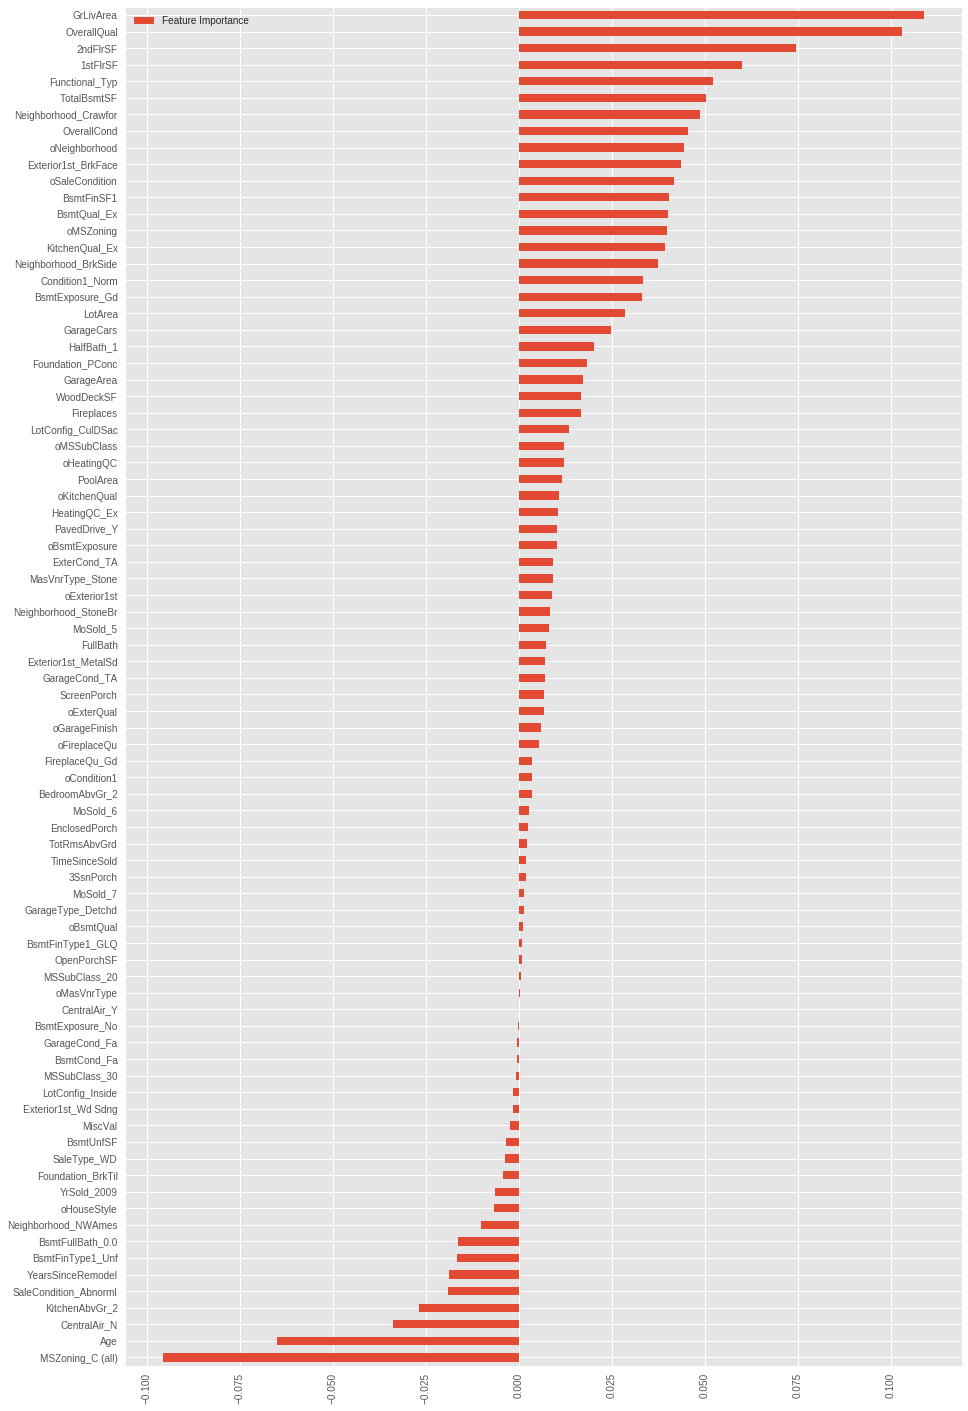

In [5322]:
FI_lasso[FI_lasso["Feature Importance"]!=0].sort_values("Feature Importance").plot(kind="barh",figsize=(15,25))
plt.xticks(rotation=90)
plt.show()

In [5323]:
"""
    factorize:将分类特征转换成连续的数字
    all_df["HasShed"] = (df["MiscFeature"] == "Shed") * 1　：满足这个条件的列的值变为1.0
    replace:值替换
"""

'\n    factorize:将分类特征转换成连续的数字\n    all_df["HasShed"] = (df["MiscFeature"] == "Shed") * 1\u3000：满足这个条件的列的值变为1.0\n    replace:值替换\n'

In [5324]:
class add_feature(BaseEstimator, TransformerMixin):
    def __init__(self,additional=1):
        self.additional = additional
    
    def fit(self,X,y=None):
        return self
    
    def transform(self,X):
        if self.additional==1:
            #整个房子的面积
            X["TotalHouse"] = X["TotalBsmtSF"] + X["1stFlrSF"] + X["2ndFlrSF"]   
            #整个房子的区域（包括停车场）
            X["TotalArea"] = X["TotalBsmtSF"] + X["1stFlrSF"] + X["2ndFlrSF"] + X["GarageArea"]
            
        else:
            X["TotalHouse"] = X["TotalBsmtSF"] + X["1stFlrSF"] + X["2ndFlrSF"]   
            X["TotalArea"] = X["TotalBsmtSF"] + X["1stFlrSF"] + X["2ndFlrSF"] + X["GarageArea"]
            
            X["+_TotalHouse_OverallQual"] = X["TotalHouse"] * X["OverallQual"]
            X["+_GrLivArea_OverallQual"] = X["GrLivArea"] * X["OverallQual"]
            
            X["+_oMSZoning_TotalHouse"] = X["oMSZoning"] * X["TotalHouse"]
            X["+_oMSZoning_OverallQual"] = X["oMSZoning"] + X["OverallQual"]
            X["+_oMSZoning_YearBuilt"] = X["oMSZoning"] + X["YearBuilt"]
            
            X["+_oNeighborhood_TotalHouse"] = X["oNeighborhood"] * X["TotalHouse"]
            X["+_oNeighborhood_OverallQual"] = X["oNeighborhood"] + X["OverallQual"]
            X["+_oNeighborhood_YearBuilt"] = X["oNeighborhood"] + X["YearBuilt"]
            
            X["+_BsmtFinSF1_OverallQual"] = X["BsmtFinSF1"] * X["OverallQual"]
            
            X["-_oFunctional_TotalHouse"] = X["oFunctional"] * X["TotalHouse"]
            X["-_oFunctional_OverallQual"] = X["oFunctional"] + X["OverallQual"]
            X["-_LotArea_OverallQual"] = X["LotArea"] * X["OverallQual"]
            X["-_TotalHouse_LotArea"] = X["TotalHouse"] + X["LotArea"]
            X["-_oCondition1_TotalHouse"] = X["oCondition1"] * X["TotalHouse"]
            X["-_oCondition1_OverallQual"] = X["oCondition1"] + X["OverallQual"]
            
            X["Bsmt"] = X["BsmtFinSF1"] + X["BsmtFinSF2"] + X["BsmtUnfSF"]
            X["Rooms"] = X["FullBath"]+X["TotRmsAbvGrd"]
            X["PorchArea"] = X["OpenPorchSF"]+X["EnclosedPorch"]+X["3SsnPorch"]+X["ScreenPorch"]
            X["TotalPlace"] = X["TotalBsmtSF"] + X["1stFlrSF"] + X["2ndFlrSF"] + X["GarageArea"] + X["OpenPorchSF"]+X["EnclosedPorch"]+X["3SsnPorch"]+X["ScreenPorch"]
            
            #这里我还要新增特征
            """
            # Overall quality of the house
            X["OverallGrade"] = X["OverallQual"] * X["OverallCond"]
            # Overall quality of the garage
            X["GarageGrade"] = X["GarageQual"] * X["GarageCond"]
            # Overall quality of the exterior
            X["ExterGrade"] = X["ExterQual"] * X["ExterCond"]
            # Overall fireplace score
            X["FireplaceScore"] = X["Fireplaces"] * X["FireplaceQu"]
            # Overall garage score
            X["GarageScore"] = X["GarageArea"] * X["GarageQual"]
            # Overall pool score
            #X["PoolScore"] = X["PoolArea"] * X["PoolQC"]
            # Simplified overall quality of the house
            X["SimplOverallGrade"] = X["OverallQual"] * X["OverallCond"]
            # Simplified overall quality of the exterior
            X["SimplExterGrade"] = X["ExterQual"] * X["ExterCond"]
            # Simplified overall pool score(PoolQC可以抛掉，据说对SalePrice没有影响)
            #X["SimplPoolScore"] = X["PoolArea"] * X["PoolQC"]
            # Simplified overall garage score
            X["SimplGarageScore"] = X["GarageArea"] * X["GarageQual"]
            # Simplified overall fireplace score
            X["SimplFireplaceScore"] = X["Fireplaces"] * X["FireplaceQu"]
            # Total number of bathrooms
#             X["TotalBath"] = X["BsmtFullBath"] + (0.5 * X["BsmtHalfBath"]) + \
#             X["FullBath"] + (0.5 * X["HalfBath"])
            """
            
            
            return X

In [5325]:
pipe = Pipeline([
    ('labenc', labelenc()),
    ('add_feature', add_feature(additional=2)),
    ('skew_dummies', skew_dummies(skew=1)),
    ])

In [5326]:
# full_pipe["oNeighborhood"] 

In [5327]:
full["GarageQual"].dtypes
full["GarageCond"].dtypes

dtype('O')

In [5328]:
full_pipe = pipe.fit_transform(full)


there are 30 skewed numerical features to Box Cox transform


In [5329]:
# full_pipe.columns[-100:]
full_pipe.isnull().sum()[full_pipe.isnull().sum()>0]

Series([], dtype: int64)

In [5330]:
full_pipe.shape

(2917, 430)

In [5331]:
n_train=train.shape[0]
X = full_pipe[:n_train]
test_X = full_pipe[n_train:]
y= train.SalePrice

X_scaled = scaler.fit(X).transform(X)
y_log = np.log(train.SalePrice)
test_X_scaled = scaler.transform(test_X)

In [5332]:
#直接对 X 应用特征重要性排序操作
def get_important_feature():
    ridge=Ridge(alpha=50)
    etr = RandomForestRegressor(n_estimators=400)
    gbr = GradientBoostingRegressor()   #默认的树的数目是100

    lasso.fit(X_scaled,y_log)
    FI_lasso = pd.DataFrame({"Feature Importance lasso":abs(lasso.coef_)}, index=full_pipe.columns)
    ridge.fit(X_scaled,y_log)
    FI_ridge = pd.DataFrame({"Feature Importance ridge":abs(ridge.coef_)}, index=full_pipe.columns)
    etr.fit(X_scaled,y_log)
    FI_randomForest = pd.DataFrame({"Feature Importance etr":etr.feature_importances_}, index=full_pipe.columns)
    gbr.fit(X_scaled, y_log)
    FI_gbr = pd.DataFrame({"Feature Importance gbr": etr.feature_importances_}, index=full_pipe.columns)

    #综合重要性特征
    models_col_importance = pd.concat([FI_lasso, FI_ridge, FI_randomForest, FI_gbr], axis=1)

    models_col_importance["sum_feature_importance"] = models_col_importance["Feature Importance lasso"] + models_col_importance["Feature Importance ridge"] + models_col_importance["Feature Importance etr"] + models_col_importance["Feature Importance gbr"]
    models_col_importance_sort = models_col_importance[models_col_importance["sum_feature_importance"]>0.0001].sort_values(by="sum_feature_importance", ascending=False).index

    #整理full_pipe,剔除部分列
    for index in X.columns:
        if index not in models_col_importance_sort:
            print(index)
            del X[index]
            del test_X[index]

    #再次缩放X和test_X
    X_scaled = scaler.fit(X).transform(X)
    test_X_scaled = scaler.transform(test_X)

In [5333]:
# get_important_feature()

In [5334]:
X_scaled.shape, test_X_scaled.shape

((1458, 430), (1459, 430))

In [ ]:
"""
    在作者的案例中，本来认为进行PCA降维的作用不大，结果发现进行PCA降维之后，在排行榜上面的得分高了很多
    或许原因死因为作者创建的特征大部分是高度相关的，所以导致了多重共线性．PCA可以让这些特征变得不那么相关
"""

In [5335]:
pca = PCA(n_components=410)   #这里进行维度调整会不会有更大提高

In [5336]:
X_scaled=pca.fit_transform(X_scaled)
test_X_scaled = pca.transform(test_X_scaled)

In [5337]:
# X_scaled.shape, test_X_scaled.shape

In [5338]:
# define cross validation strategy
def rmse_cv(model,X,y):
    rmse = np.sqrt(-cross_val_score(model, X, y, scoring="neg_mean_squared_error", cv=5))
    return rmse

In [5339]:
def rmsle(y, y_pred):
    return np.sqrt(mean_squared_error(y, y_pred))

In [5340]:
models = [LinearRegression(),Ridge(),Lasso(alpha=0.01,max_iter=10000),
          RandomForestRegressor(),GradientBoostingRegressor(),
          SVR(),LinearSVR(),
          ElasticNet(alpha=0.001,max_iter=10000),
          SGDRegressor(max_iter=1000,tol=1e-3),
          BayesianRidge(),KernelRidge(alpha=0.6, kernel='polynomial', degree=2, coef0=2.5),
          ExtraTreesRegressor(),XGBRegressor()]

In [5341]:
names = ["LR", "Ridge", "Lasso", "RF", "GBR", "SVR", "LinSVR", "Ela","SGD","Bay","Ker","Extra","Xgb"]
for name, model in zip(names, models):
    score = rmse_cv(model, X_scaled, y_log)
    print("{}: {:.6f}, {:.4f}".format(name,score.mean(),score.std()))

LR: 16669099079.069477, 20242131903.6707
Ridge: 0.117475, 0.0091
Lasso: 0.121861, 0.0056
RF: 0.137675, 0.0063
GBR: 0.124534, 0.0052
SVR: 0.112529, 0.0045
LinSVR: 0.120841, 0.0100
Ela: 0.110895, 0.0061
SGD: 0.168125, 0.0156
Bay: 0.110656, 0.0059
Ker: 0.109357, 0.0054
Extra: 0.137378, 0.0055
Xgb: 0.122304, 0.0066


In [5342]:
#网格搜索
class grid():
    def __init__(self,model):
        self.model = model
    
    def grid_get(self,X,y,param_grid):
        grid_search = GridSearchCV(self.model,param_grid,cv=5, scoring="neg_mean_squared_error")
        grid_search.fit(X,y)
        print(grid_search.best_params_, np.sqrt(-grid_search.best_score_))
        grid_search.cv_results_['mean_test_score'] = np.sqrt(-grid_search.cv_results_['mean_test_score'])
        print(pd.DataFrame(grid_search.cv_results_)[['params','mean_test_score','std_test_score']])

In [5343]:
"""
下面的这些模型的参数的微调：
    根据经验，选出对模型效果影响较大的超参数
    根据经验设置超参数的搜索空间
"""

'\n下面的这些模型的参数的微调：\n    根据经验，选出对模型效果影响较大的超参数\n    根据经验设置超参数的搜索空间\n'

In [5344]:
grid(Lasso()).grid_get(X_scaled,y_log,{'alpha': [0.0004,0.0005,0.0007,0.0009],'max_iter':[10000]})

{'alpha': 0.0005, 'max_iter': 10000} 0.111116959164
                                 params  mean_test_score  std_test_score
0  {'alpha': 0.0004, 'max_iter': 10000}         0.111249        0.001434
1  {'alpha': 0.0005, 'max_iter': 10000}         0.111117        0.001382
2  {'alpha': 0.0007, 'max_iter': 10000}         0.111132        0.001306
3  {'alpha': 0.0009, 'max_iter': 10000}         0.111410        0.001245


In [5345]:
# self.model.loc[30:,["test-rmse-mean", "train-rmse-mean"]].plot()

In [5346]:
grid(Ridge()).grid_get(X_scaled,y_log,{'alpha':[35,40,45,50,55,60,65,70,80,90]})

{'alpha': 65} 0.110332720477
          params  mean_test_score  std_test_score
0  {'alpha': 35}         0.110502        0.001261
1  {'alpha': 40}         0.110436        0.001242
2  {'alpha': 45}         0.110391        0.001226
3  {'alpha': 50}         0.110360        0.001213
4  {'alpha': 55}         0.110342        0.001203
5  {'alpha': 60}         0.110333        0.001194
6  {'alpha': 65}         0.110333        0.001186
7  {'alpha': 70}         0.110339        0.001180
8  {'alpha': 80}         0.110367        0.001169
9  {'alpha': 90}         0.110412        0.001162


In [5347]:
grid(SVR()).grid_get(X_scaled,y_log,{'C':[11,13,15],'kernel':["rbf"],"gamma":[0.0003,0.0004],"epsilon":[0.008,0.009]})

{'C': 15, 'epsilon': 0.008, 'gamma': 0.0004, 'kernel': 'rbf'} 0.108157498538
                                               params  mean_test_score  \
0   {'C': 11, 'epsilon': 0.008, 'gamma': 0.0003, '...         0.108654   
1   {'C': 11, 'epsilon': 0.008, 'gamma': 0.0004, '...         0.108279   
2   {'C': 11, 'epsilon': 0.009, 'gamma': 0.0003, '...         0.108605   
3   {'C': 11, 'epsilon': 0.009, 'gamma': 0.0004, '...         0.108263   
4   {'C': 13, 'epsilon': 0.008, 'gamma': 0.0003, '...         0.108577   
5   {'C': 13, 'epsilon': 0.008, 'gamma': 0.0004, '...         0.108201   
6   {'C': 13, 'epsilon': 0.009, 'gamma': 0.0003, '...         0.108535   
7   {'C': 13, 'epsilon': 0.009, 'gamma': 0.0004, '...         0.108196   
8   {'C': 15, 'epsilon': 0.008, 'gamma': 0.0003, '...         0.108454   
9   {'C': 15, 'epsilon': 0.008, 'gamma': 0.0004, '...         0.108157   
10  {'C': 15, 'epsilon': 0.009, 'gamma': 0.0003, '...         0.108435   
11  {'C': 15, 'epsilon': 0.009, 'ga

In [5348]:
param_grid={'alpha':[0.2,0.3,0.4], 'kernel':["polynomial"], 'degree':[3],'coef0':[0.8,1]}
grid(KernelRidge()).grid_get(X_scaled,y_log,param_grid)

{'alpha': 0.3, 'coef0': 1, 'degree': 3, 'kernel': 'polynomial'} 0.108350963808
                                              params  mean_test_score  \
0  {'alpha': 0.2, 'coef0': 0.8, 'degree': 3, 'ker...         0.108361   
1  {'alpha': 0.2, 'coef0': 1, 'degree': 3, 'kerne...         0.108604   
2  {'alpha': 0.3, 'coef0': 0.8, 'degree': 3, 'ker...         0.108461   
3  {'alpha': 0.3, 'coef0': 1, 'degree': 3, 'kerne...         0.108351   
4  {'alpha': 0.4, 'coef0': 0.8, 'degree': 3, 'ker...         0.108797   
5  {'alpha': 0.4, 'coef0': 1, 'degree': 3, 'kerne...         0.108354   

   std_test_score  
0        0.001193  
1        0.001228  
2        0.001171  
3        0.001194  
4        0.001161  
5        0.001173  


In [5349]:
grid(ElasticNet()).grid_get(X_scaled,y_log,{'alpha':[0.0008,0.004,0.005],'l1_ratio':[0.08,0.1,0.3],'max_iter':[10000]})

{'alpha': 0.005, 'l1_ratio': 0.1, 'max_iter': 10000} 0.11088653614
                                              params  mean_test_score  \
0  {'alpha': 0.0008, 'l1_ratio': 0.08, 'max_iter'...         0.115280   
1  {'alpha': 0.0008, 'l1_ratio': 0.1, 'max_iter':...         0.114687   
2  {'alpha': 0.0008, 'l1_ratio': 0.3, 'max_iter':...         0.112077   
3  {'alpha': 0.004, 'l1_ratio': 0.08, 'max_iter':...         0.111096   
4  {'alpha': 0.004, 'l1_ratio': 0.1, 'max_iter': ...         0.110936   
5  {'alpha': 0.004, 'l1_ratio': 0.3, 'max_iter': ...         0.112008   
6  {'alpha': 0.005, 'l1_ratio': 0.08, 'max_iter':...         0.110892   
7  {'alpha': 0.005, 'l1_ratio': 0.1, 'max_iter': ...         0.110887   
8  {'alpha': 0.005, 'l1_ratio': 0.3, 'max_iter': ...         0.112488   

   std_test_score  
0        0.002005  
1        0.001949  
2        0.001591  
3        0.001417  
4        0.001368  
5        0.001185  
6        0.001354  
7        0.001316  
8        0.001171  


In [5350]:
class AverageWeight(BaseEstimator, RegressorMixin):
    def __init__(self,mod,weight):
        self.mod = mod
        self.weight = weight
        
    def fit(self,X,y):
        self.models_ = [clone(x) for x in self.mod]   #构造一个具有相同参数的新的评估器
        for model in self.models_:
            model.fit(X,y)
        return self
    
    def predict(self,X):
        w = list()
        #每个模型都对数据进行预测，然后将所有的结果保存在一个大型数组中
        pred = np.array([model.predict(X) for model in self.models_])
        # for every data point, single model prediction times weight, then add them together
        #遍历每一个数据样本，对每个样本进行模型预测之后的加权平均
        for data in range(pred.shape[1]):
            single = [pred[model,data]*weight for model,weight in zip(range(pred.shape[0]),self.weight)]
            w.append(np.sum(single))
        return w

In [5351]:
#用之前网格搜索之后的最佳超参数来给定每一个模型
lasso = Lasso(alpha=0.0005, max_iter=10000)
ridge = Ridge(alpha=60)
svr = SVR(gamma=0.0004, kernel="rbf", C=13, epsilon=0.009)
ker = KernelRidge(alpha=0.2, kernel="polynomial", degree=3, coef0=0.8)
ela = ElasticNet(alpha=0.005, l1_ratio=0.08, max_iter=10000)
bay = BayesianRidge()

In [5352]:

"""
那五个模型的得分：
0.111481
0.110687
0.108557
0.108733
0.111382
"""
#总和为１,基于网格搜索的得分来给定权重
w1 = 0.02
w2 = 0.2
w3 = 0.25
w4 = 0.3
w5 = 0.03
w6 = 0.2


In [5353]:
#六个模型的加权平均
weight_avg = AverageWeight(mod=[lasso, ridge, svr, ker, ela, bay], weight=[w1,w2,w3,w4,w5,w6])
#这里求了score.mean 因为rmse中引用了cross_val_score，返回的是由k折交叉验证中每一次的试验结果组成的列表
score = rmse_cv(weight_avg, X_scaled, y_log) 
print(score.mean())

0.107717019243


In [5354]:
#如果仅仅用两个最好的模型
weight_avg = AverageWeight(mod=[svr, ker], weight=[0.5, 0.5])
score = rmse_cv(weight_avg, X_scaled, y_log)
print(score.mean())

0.106715122204


In [5355]:
"""
    Stacking:
        get_oof:用来包含由stacking 产生的特征和原始的特征
    Stacking原理：
        对于每一个模型，假设进行５折交叉验证，每一次交叉验证，model1会对１/5的训练数据进行预测，会对整个数据集进行预测，所以５次过后，形成对整个训练集的预测，
        称为A1,形成对整个测试集的预测，取5次的均值，称为B1,如果是5个模型，假设训练集大小为10000,测试集大小为2500,第一层的5个模型训练完之后，就会有10000*5
        的新的训练数据集，2500*5的新的预测数据集
        然后下一层的模型，基于这个进行训练，但是这些数据都是有噪声的，怎么可以直接用呢？
    疑问：
        Stacking一共有多少层模型，每一层的模型是如何定义的
"""


'\n    Stacking:\n        get_oof:用来包含由stacking 产生的特征和原始的特征\n    Stacking原理：\n        对于每一个模型，假设进行５折交叉验证，每一次交叉验证，model1会对１/5的训练数据进行预测，会对整个数据集进行预测，所以５次过后，形成对整个训练集的预测，\n        称为A1,形成对整个测试集的预测，取5次的均值，称为B1,如果是5个模型，假设训练集大小为10000,测试集大小为2500,第一层的5个模型训练完之后，就会有10000*5\n        的新的训练数据集，2500*5的新的预测数据集\n        然后下一层的模型，基于这个进行训练，但是这些数据都是有噪声的，怎么可以直接用呢？\n    疑问：\n        Stacking一共有多少层模型，每一层的模型是如何定义的\n'

In [5356]:
class stacking(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, mod, meta_model):
        self.mod = mod
        self.meta_model = meta_model     #这个meta模型是目前唯一不知道的,指第二层需要用到的模型，自己指定
        self.kf = KFold(n_splits=5, random_state=42, shuffle=True)
    
    def fit(self, X, y):
        self.saved_model = [list() for i in self.mod]
        oof_train = np.zeros((X.shape[0], len(self.mod)))
        
        for i,model in enumerate(self.mod):
            for train_index, val_index in self.kf.split(X,y):   #k折交叉验证划分出了一批训练集和测试集
                renew_model = clone(model)   #构造一个参数相同的新的评估器
                renew_model.fit(X[train_index], y[train_index])
                self.saved_model[i].append(renew_model)  #每一个模型可以训练出5个新模型，保存起来之后应用于测试集
                oof_train[val_index, i] = renew_model.predict(X[val_index]) #对验证集进行预测
        self.meta_model.fit(oof_train,y)
        return self
    
    #每一次的新模型对测试集X进行预测，取均值
    def predict(self, X):
        whole_test = np.column_stack([np.column_stack(model.predict(X) for model in single_model).mean(axis=1) 
                                            for single_model in self.saved_model])
        return self.meta_model.predict(whole_test)
    
    #这个方法的主要作用是如果获取新模型
    def get_oof(self, X, y, test_X):
        oof = np.zeros((X.shape[0], len(self.mod)))
        test_single = np.zeros((test_X.shape[0], 5))  #用来存储一个模型５次交叉验证的值，每一次交叉验证的模型都会对测试集进行预测
        test_mean = np.zeros((test_X.shape[0], len(self.mod)))   #该模型５次交叉验证的测试的均值
        for i, model in enumerate(self.mod):
            for j, (train_index, val_index) in enumerate(self.kf.split(X,y)):
                clone_model = clone(model)
                clone_model.fit(X[train_index], y[train_index])        #拟合出一个新模型
                oof[val_index, i] = clone_model.predict(X[val_index])  #对验证集的预测
                test_single[:, j] = clone_model.predict(test_X)   #保留每一次交叉验证的测试的结果  
            test_mean[:, i] = test_single.mean(axis=1)   #５次交叉验证对测试集求解后的均值
        return oof, test_mean

In [5357]:
#处理缺失值（前面特征处理的第一步就是处理缺失值，为什么这里还要处理缺失值）
a = Imputer().fit_transform(X_scaled)
b = Imputer().fit_transform(y_log.values.reshape(-1,1)).ravel()

In [5358]:
stack_model = stacking(mod=[lasso, ridge, svr, ker, ela, bay], meta_model=ker)    #应该一共也就两层模型

In [5359]:
score=rmse_cv(stack_model, a, b)
print(score.mean())

0.106593468892


In [5360]:
#现在从stacking中提取出特征，并包含进原始特征中

In [5361]:
X_train_stack, X_test_stack = stack_model.get_oof(a,b,test_X_scaled)

In [5362]:
X_train_stack.shape, a.shape

((1458, 6), (1458, 410))

In [5363]:
#行数不变，列合并
X_train_add = np.hstack((a, X_train_stack))

In [5364]:
X_test_add = np.hstack((test_X_scaled, X_test_stack))

In [5365]:
X_train_add.shape, X_test_add.shape

((1458, 416), (1459, 416))

In [5366]:
score = rmse_cv(stack_model, X_train_add, b)
print(score.mean())

0.10201877646


In [5367]:
score

array([ 0.09920177,  0.10483697,  0.11215077,  0.09424786,  0.09965652])

In [5368]:
#进行提交
#最终的模型
stack_model = stacking(mod=[lasso, ridge, svr, ker, ela, bay], meta_model=ker)

In [5369]:
stack_model.fit(a,b)

stacking(meta_model=KernelRidge(alpha=0.2, coef0=0.8, degree=3, gamma=None, kernel='polynomial',
      kernel_params=None),
     mod=[Lasso(alpha=0.0005, copy_X=True, fit_intercept=True, max_iter=10000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False), Ridge(alpha=60, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=No...True, lambda_1=1e-06, lambda_2=1e-06, n_iter=300,
       normalize=False, tol=0.001, verbose=False)])

In [5370]:
a.shape, X_train_add.shape, X_test_add.shape, test_X_scaled.shape

((1458, 410), (1458, 416), (1459, 416), (1459, 410))

In [5371]:
#没有加e的指数
pred_train = np.exp(stack_model.predict(a))

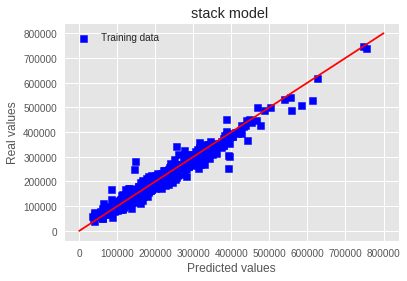

In [5372]:
#这里进行误差分析，观察距离真正预测房价差别较大的样本有什么特征
#最相似的样本，又有什么特征？(特征太多，难以捕捉相似点，不像文本理解，可以以人的理解来提出问题)
#没有足够多的样本，只能在训练上进行预测

plt.scatter(y, pred_train, c="blue", marker="s", label="Training data")
plt.title("stack model ")
plt.xlabel("Predicted values")
plt.ylabel("Real values")
plt.legend(loc="upper left")
plt.plot([0, 800000], [0, 800000], c ="red")
plt.show()

In [5373]:
#打印出真实值和预测值相差较大的样本，拿到样本index, 看看有什么特征
list_index = []
for index in y.index[:-2]:
    if(abs(pred_train[index]-y.values[index])/y.values[index]) > 0.3:
#         if index==1458:
#             print(train.iloc[index:])
#             break
#         print(train.iloc[index:index+1])
        list_index.append(index)
        print(index, "\t", y.values[index], "\t", pred_train[index])

30 	 40000 	 76205.8329827
88 	 85000 	 58100.3076531
410 	 60000 	 92817.3056679
462 	 62383 	 114219.871255
495 	 34900 	 60765.678465
559 	 121500 	 168636.469398
580 	 253293 	 342430.829561
587 	 143000 	 248880.099387
631 	 82500 	 169204.049033
665 	 129000 	 172644.529458
687 	 392000 	 253986.152165
713 	 130500 	 175199.493196
727 	 110000 	 144810.815599
811 	 55993 	 79079.4883403
873 	 66500 	 91379.0038863
915 	 35311 	 48941.5765532
967 	 37900 	 66818.2111274
969 	 135000 	 91569.2155288
1061 	 90000 	 117365.773309
1322 	 147000 	 281160.884726
1381 	 112000 	 148209.717387
1430 	 64500 	 95116.9233714
1451 	 84500 	 130737.925827


In [5374]:
# train.loc[list_index]

In [5375]:
#对训练集进行预测，当然准确
rmsle(pred_train, y)

15171.446588269595

In [5376]:
#在测试集上进行测试
pred = np.exp(stack_model.predict(test_X_scaled))

In [5377]:
pred[:100]

array([ 120513.83820742,  166331.62943407,  192432.06367598,
        203153.79752169,  192306.77921823,  173509.5457949 ,
        178444.22513109,  166552.70286396,  194223.25720385,
        124791.67951362,  184335.524923  ,   95318.72365705,
         94548.46051404,  148354.13948067,  113341.02166391,
        371889.33885578,  253760.87770682,  297206.31412178,
        289829.58494173,  528265.89304181,  326510.35938323,
        214298.21766373,  183563.75366355,  164799.79483769,
        184092.3178399 ,  195881.55643996,  351689.11394647,
        236530.65313196,  198204.80956958,  250818.96751528,
        196738.35533226,   92901.01730949,  186334.85204388,
        287250.35251661,  291580.82333068,  241632.42696473,
        185831.40730398,  169412.46996746,  169908.95617976,
        165191.42676145,  181050.62283262,  143759.40238992,
        298325.70299568,  241125.35384995,  228652.46025408,
        191623.93978669,  260418.19148253,  204680.75280156,
        162539.12849792,

In [5378]:
result=pd.DataFrame({'Id':test.Id, 'SalePrice':pred})
result.to_csv("result/submission_better_x_add_201807122225.csv",index=False)

In [5379]:
"""
存在的问题：

"""

'\n存在的问题：\n\n'

In [5380]:
"""
可能的提高：
    特征组合，缺失值填充，单个模型的优化
    缩放Ｘ的某些特征，使得其趋近于正态分布?
    捕捉重要特征，其他模型融合方法，更好的模型选择
"""

'\n可能的提高：\n    特征组合，缺失值填充，单个模型的优化\n    缩放Ｘ的某些特征，使得其趋近于正态分布?\n    捕捉重要特征，其他模型融合方法，更好的模型选择\n'

In [5381]:
"""
    测试结果的记录：
        在原作者的基础上使用fill_missing_zl()：效果更差
            0.108309153331，0.107343989228，0.10766516777，0.104229592706
        在原作者的基础上加入新的特征：（几乎没有提升）
            0.107986628935，0.107986628935，0.106880549499，0.101645102887
        对top10的特征进行多项式整合：（效果更差）
            0.107707671111，0.107214578427，0.107151437006，0.102734124328
        处理skew,换成BoxCox1p:（效果更差）
            0.10228101893
"""

'\n    测试结果的记录：\n        在原作者的基础上使用fill_missing_zl()：效果更差\n            0.108309153331，0.107343989228，0.10766516777，0.104229592706\n        在原作者的基础上加入新的特征：（几乎没有提升）\n            0.107986628935，0.107986628935，0.106880549499，0.101645102887\n        对top10的特征进行多项式整合：（效果更差）\n            0.107707671111，0.107214578427，0.107151437006，0.102734124328\n        处理skew,换成BoxCox1p:（效果更差）\n            0.10228101893\n'